Ho eseguito l'esercizio anche in questo modo cercando di gestire un problema di classi sbilanciate (con una prevalenza della classe minoritaria molto bassa). Ho applicato SMOTE per aumentare la classe minoritaria (i malati). In questo modo ottengo comunque una recall alta e un F1-score decisamente migliore di quello del testo.

Nel complesso quindi il modello  ottenuto è meno problematico rispetto a quello descritto nel testo, dove si fa riferimento a un modello con un basso F1-score e precisione e una recall alta. Qui, pur avendo una recall abbastanza buona, il modello non soffre di un'alta quantità di falsi positivi come nel caso descritto nel testo.

Dopo SMOTE - Distribuzione delle classi nel training set:
target
0    69650
1    69650
Name: count, dtype: int64
Classification Report (per classe):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29850
           1       0.58      0.81      0.68       150

    accuracy                           1.00     30000
   macro avg       0.79      0.91      0.84     30000
weighted avg       1.00      1.00      1.00     30000



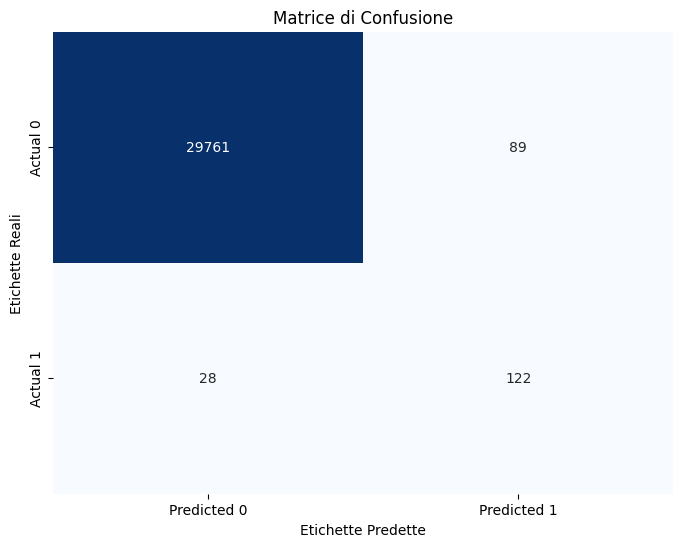

F1-Score globale: 0.676
Recall globale: 0.813


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni casuali per la riproducibilità
np.random.seed(42)

# Parametri iniziali
prevalence = 0.005  # Prevalenza della malattia (0.5%)

# Crea un set di dati sbilanciato con il 90% di campioni nella classe 0 e il 10% nella classe 1
X, y = make_classification(
    n_samples=100000, 
    n_features=10,
    n_informative=5, 
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[1-prevalence],  # Distribuzione delle classi: 90% classe 0, 10% classe 1
    flip_y=0,
    random_state=42
)

# Converti in DataFrame per una manipolazione più semplice
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y

# Split del dataset
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Applicazione di SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verifica la nuova distribuzione delle classi nel training set
print(f"Dopo SMOTE - Distribuzione delle classi nel training set:\n{pd.Series(y_train_smote).value_counts()}")

# Funzione per valutare il modello
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Allena il modello
    model.fit(X_train, y_train)
    
    # Fai le predizioni
    y_pred = model.predict(X_test)
    
    # Calcola F1-Score e Recall
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Stampa il report di classificazione per le singole classi
    print("Classification Report (per classe):")
    print(classification_report(y_test, y_pred))
    
    # Visualizza la matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Matrice di Confusione')
    plt.ylabel('Etichette Reali')
    plt.xlabel('Etichette Predette')
    plt.show()
    
    # Stampa F1-Score e Recall globali
    print(f"F1-Score globale: {f1:.3f}")
    print(f"Recall globale: {recall:.3f}")
    
    return {'f1_score': f1, 'recall': recall}

# Allena il modello dopo SMOTE
smote_model = RandomForestClassifier(random_state=42)
smote_results = evaluate_model(smote_model, X_train_smote, X_test, y_train_smote, y_test)
